<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_02_03_survival_analysis_stratified_cox_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.3 Stratified Cox Model


This tutorial explains the concept of **Stratified Cox Model** in
survival analysis, why they are important, how to implement them, and
the assumptions involved. It also provides practical examples and code
snippets in R.


## Overview


The Stratified Cox Proportional Hazards Model is a modification of the
standard Cox Proportional Hazards (PH) model, which is a semi-parametric
method used in survival analysis to assess the impact of covariates on
the hazard rate of an event (e.g., death, failure) over time. The
standard Cox model assumes that the hazard ratios are constant over time
(the PH assumption), meaning the effect of covariates on the hazard is
proportional and does not change.

However, this assumption can be violated for certain covariates, such as
categorical factors like treatment group or tumor type, where the hazard
functions cross or diverge non-proportionally. The stratified version
addresses this by dividing the data into strata based on the levels of
the violating covariate (e.g., different categories of a variable).
Within each stratum, a separate baseline hazard function ( h\_{0j}(t) )
is estimated, allowing it to vary across strata. The model takes the
form:

$$
h_{ij}(t) = h_{0j}(t) \exp(\mathbf{x}_i^T \boldsymbol{\beta})
$$

where: - $i$ indexes individuals, - $j$ indexes strata, - $h_{0j}(t)$ is
the stratum-specific baseline hazard, - $\mathbf{x}_i$ are the
covariates (excluding the stratification variable), -
$\boldsymbol{\beta}$ are the regression coefficients, assumed to be the
same across all strata.

This approach controls for the stratifying variable without estimating a
coefficient for it, meaning you cannot directly test or quantify its
effect on the hazard. The partial likelihood is the product of
stratum-specific likelihoods, and estimation proceeds by summing
contributions from each stratum (e.g., via Newton-Raphson optimization).


### Key advantages


-   Handles non-PH for the stratifying variable without needing
    time-dependent covariates.
-   Useful for sensitivity analyses or when the stratifying factor is a
    confounder (e.g., study site in multi-center trials).


## Limitations


-   Reduces statistical efficiency slightly if stratification is
    unnecessary.
-   No inference (e.g., p-values) for the stratification variable.
-   Best for categorical variables with few levels; challenging for
    continuous or many-level variables.

The PH assumption must still hold within each stratum for the remaining
covariates. Diagnostics like Schoenfeld residuals (via `cox.zph()` in R)
or plots of log cumulative hazards can check for violations before
deciding to stratify.


## Cheeck and Load Required Packages

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
lifelines is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✓ lifelines


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test

# survival_probability_calibration can be located in different modules across lifelines versions.
# Try the common locations and fall back gracefully if unavailable.
try:
	from lifelines.utils import survival_probability_calibration
except Exception:
	try:
		from lifelines.calibration import survival_probability_calibration
	except Exception:
		survival_probability_calibration = None
		import warnings
		warnings.warn(
			"survival_probability_calibration is not available in this lifelines installation. "
			"Calibration features will be disabled. To enable them, upgrade lifelines or install a version that provides this function."
		)

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## Stratified Cox Model in Python

### Data

In [ ]:
# Load the dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
lung_data = pd.read_csv(url)


In [ ]:
# Create working copy
data = lung_data.copy()

# Preprocessing
# Original: sex: 1=male, 2=female → convert to 0=male, 1=female for clarity
data['sex'] = data['sex'].map({1: 0, 2: 1})
data['sex'] = data['sex'].astype('category')
data['sex_name'] = data['sex'].map({0: 'Male', 1: 'Female'})

# Handle missing values in ECOG performance score
data['ph.ecog'].fillna(data['ph.ecog'].median(), inplace=True)

# Event indicator: status == 1 → event (death), status == 2 → censored
data['event'] = (data['status'] == 1).astype(int)

# Select key variables for analysis
df = data[['time', 'event', 'age', 'sex', 'wt.loss', 'ph.ecog']].copy()

print("Dataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nEvent distribution:")
print(df['event'].value_counts(normalize=True))

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   time     228 non-null    int64   
 1   event    228 non-null    int64   
 2   age      228 non-null    int64   
 3   sex      228 non-null    category
 4   wt.loss  214 non-null    float64 
 5   ph.ecog  228 non-null    float64 
dtypes: category(1), float64(2), int64(3)
memory usage: 9.4 KB
None

First few rows:
   time  event  age sex  wt.loss  ph.ecog
0   306      0   74   0      NaN      1.0
1   455      0   68   0     15.0      0.0
2  1010      1   56   0     15.0      0.0
3   210      0   57   0     11.0      1.0
4   883      0   60   0      0.0      0.0

Event distribution:
event
0    0.723684
1    0.276316
Name: proportion, dtype: float64


/tmp/ipykernel_252258/1050238295.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ph.ecog'].fillna(data['ph.ecog'].median(), inplace=True)


### Fit a Standard (Unstratified) Cox Model


First, fit a standard Cox model to assess covariates and check the PH
assumption.


In [ ]:
# Impute missing values for covariates required by the model.
# Here we fill wt.loss missing values with the median (other strategies like dropna or more
# advanced imputation can be used depending on the analysis plan).
if df['wt.loss'].isnull().any():
	median_wt = df['wt.loss'].median()
	df['wt.loss'].fillna(median_wt, inplace=True)
	print(f"Imputed {df['wt.loss'].isnull().sum()} remaining NaNs in 'wt.loss' (filled with median={median_wt}).")

# Ensure there are no NaNs in the columns used for modelling
model_cols = ['time', 'event', 'age', 'sex', 'wt.loss', 'ph.ecog']
if df[model_cols].isnull().any().any():
	missing = df[model_cols].isnull().sum()
	raise ValueError(f"NaNs remain in required columns:\n{missing}")

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(df, duration_col='time', event_col='event')

print("=== Standard Cox Proportional Hazards Model ===")
cph.print_summary(decimals=3)

Imputed 0 remaining NaNs in 'wt.loss' (filled with median=7.0).
=== Standard Cox Proportional Hazards Model ===


/tmp/ipykernel_252258/1034507272.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wt.loss'].fillna(median_wt, inplace=True)


<lifelines.CoxPHFitter: fitted with 228 total observations, 165 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 228
number of events observed = 63
   partial log-likelihood = -258.593
         time fit was run = 2025-12-02 03:23:18 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age       -0.022     0.978     0.015          -0.051           0.007               0.950               1.007
sex        0.640     1.896     0.266           0.119           1.161               1.126               3.193
wt.loss   -0.001     0.999     0.010          -0.021           0.020               0.979               1.020
ph.ecog   -0.196     0.822     0.215          -0.617           0.224               0.540               1.252

           cmp to      z     p  -log2(p)
covariate                               
age         0.000 -1.465 0.143     2.806
sex         0.000  2.406 0.016     5.956
wt.loss     0.000 -0.055 0.956     0.065
ph.ecog     0.000 -0.914 0.360     1.472
---
Concordance = 0.583
Partial AIC = 525.185
log-likelihood ratio test = 10.285 on 4 df
-log2(p) of ll-ratio test = 4.800


Interpretation: Age and sex are significant predictors (higher age
increases hazard; females have lower hazard). Weight loss is not
significant.


### Check the Proportional Hazards Assumption

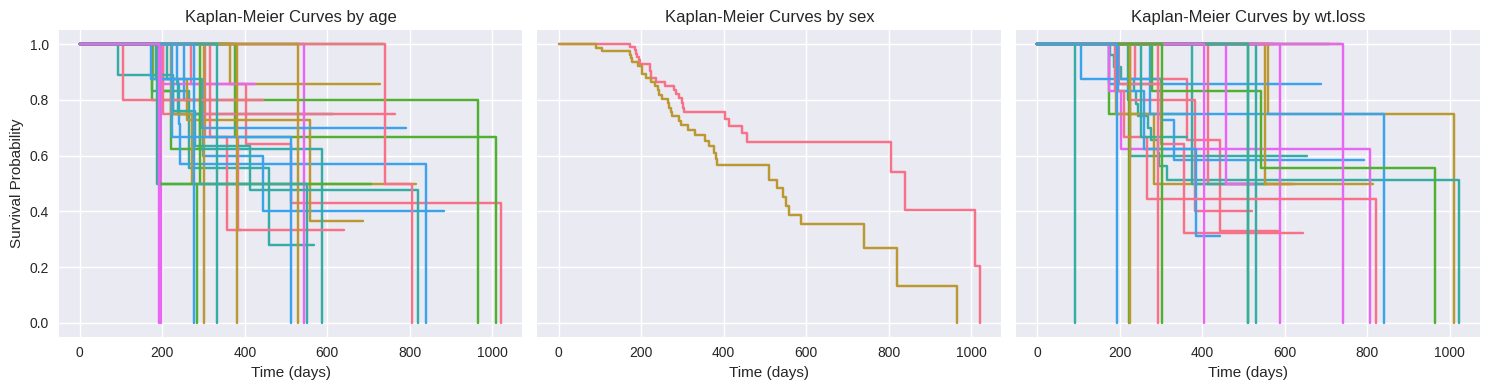

In [ ]:
# Test PH assumption using log(-log(S(t))) plots and statistical test
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

variables = ['age', 'sex', 'wt.loss']

for i, var in enumerate(variables):
    ax = axes[i]

    for value in df[var].unique():
        if df[var].dtype.name == 'category':
            label = f"{var} = {['Male','Female'][int(value)]}"
        else:
            label = f"{var} = {value}"

        mask = df[var] == value
        kmf = KaplanMeierFitter()
        kmf.fit(df[mask]['time'], df[mask]['event'], label=label)
        kmf.plot_survival_function(ax=ax, ci_show=False)

    # remove legend to simplify the figure
    try:
        leg = ax.get_legend()
        if leg:
            leg.remove()
    except Exception:
        pass

    ax.set_title(f'Kaplan-Meier Curves by {var}')
    ax.set_xlabel('Time (days)')
    if i == 0:
        ax.set_ylabel('Survival Probability')

plt.tight_layout()
plt.show()


In [ ]:
# Formal statistical test for PH assumption (using lifelines)
print("=== Proportional Hazards Test (Schoenfeld Residuals) ===")
results = proportional_hazard_test(cph, df, time_transform='rank')
results.print_summary(decimals=3)

=== Proportional Hazards Test (Schoenfeld Residuals) ===


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 228 total observations, 165 right-censored observations>
         test_name = proportional_hazard_test

---
         test_statistic    p  -log2(p)
age                0.68 0.41      1.29
ph.ecog            1.50 0.22      2.18
sex                1.34 0.25      2.02
wt.loss            4.45 0.03      4.84

If p-value for sex < 0.05 → PH assumption violated → stratification needed

### Fit the Stratified Cox Model


Stratify by the violating variable (e.g., `sex`). This allows different
baseline hazards for males and females.


In [ ]:
# Since sex likely violates PH, fit stratified model
cph_strat = CoxPHFitter()
cph_strat.fit(df, duration_col='time', event_col='event', strata=['sex'])

print("=== Stratified Cox Model (stratified by sex) ===")
cph_strat.print_summary(decimals=3)

=== Stratified Cox Model (stratified by sex) ===


/home/zia207/WebSites/Python_Website/Survival_Analaysis/.venv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
/home/zia207/WebSites/Python_Website/Survival_Analaysis/.venv/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
/home/zia207/WebSites/Python_Website/Survival_Analaysis/.venv/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=Fal

<lifelines.CoxPHFitter: fitted with 228 total observations, 165 right-censored observations>
             duration col = 'time'
                event col = 'event'
                   strata = sex
      baseline estimation = breslow
   number of observations = 228
number of events observed = 63
   partial log-likelihood = -218.060
         time fit was run = 2025-12-02 03:28:10 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age       -0.022     0.978     0.015          -0.051           0.007               0.950               1.007
wt.loss   -0.001     0.999     0.011          -0.022           0.019               0.978               1.020
ph.ecog   -0.205     0.814     0.217          -0.631           0.220               0.532               1.246

           cmp to      z     p  -log2(p)
covariate                               
age         0.000 -1.470 0.142     2.820
wt.loss     0.000 -0.120 0.904     0.145
ph.ecog     0.000 -0.946 0.344     1.539
---
Concordance = 0.539
Partial AIC = 442.120
log-likelihood ratio test = 4.175 on 3 df
-log2(p) of ll-ratio test = 2.040


Interpretation: No coefficient for `sex` (the stratifying variable).
Estimates for `age` and `wt.loss` are similar to the unstratified model,
with age borderline significant. This serves as a sensitivity check; if
results differ substantially, the PH violation may bias the original
model.


### Plot Stratum-Specific Survival Curves

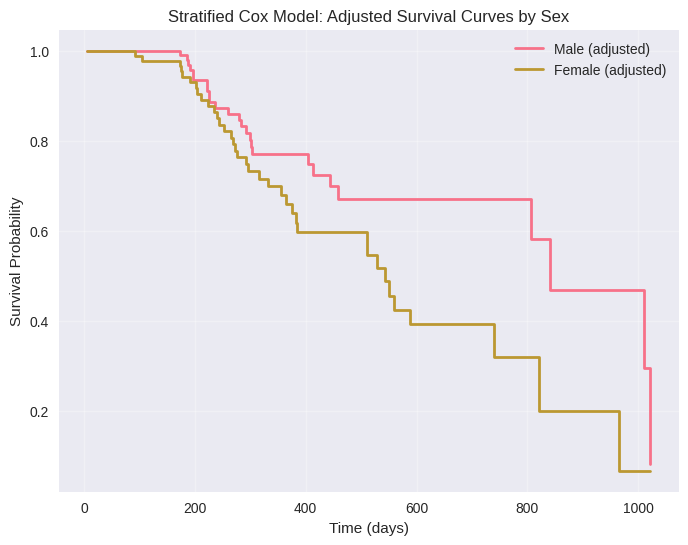

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract baseline survival for each stratum (be robust to column ordering)
bs = cph_strat.baseline_survival_
if bs.shape[1] >= 2:
    baseline_male = bs.iloc[:, 0]   # sex=0 (Male)
    baseline_female = bs.iloc[:, 1] # sex=1 (Female)
else:
    # Fallback if only one column exists (unlikely here)
    baseline_male = bs.iloc[:, 0]
    baseline_female = bs.iloc[:, 0]

# Plot adjusted survival curves (at mean covariate values)
ax.step(baseline_male.index, baseline_male.values,
        label='Male (adjusted)', where='post', linewidth=2)
ax.step(baseline_female.index, baseline_female.values,
        label='Female (adjusted)', where='post', linewidth=2)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.set_title('Stratified Cox Model: Adjusted Survival Curves by Sex')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### Predict and Plot Survival Curves


Estimate stratum-specific survival curves.


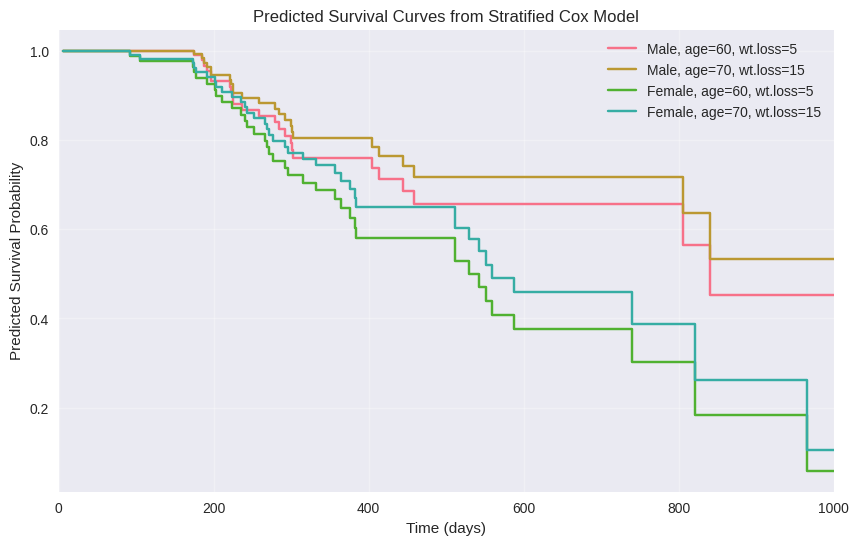

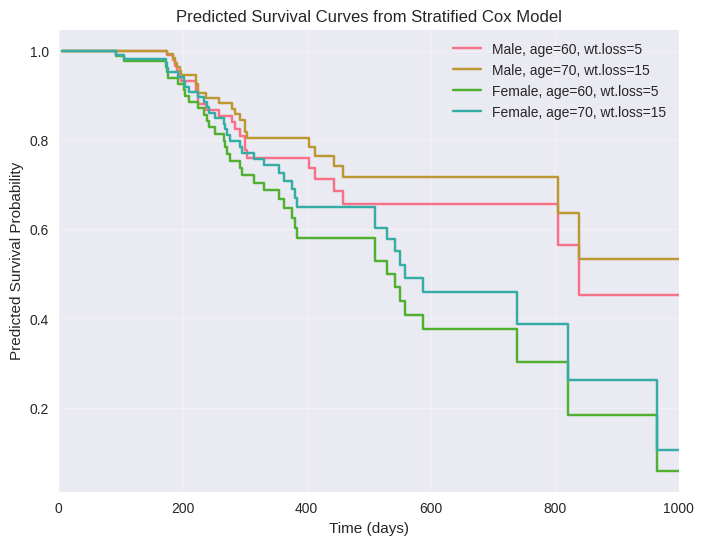

In [ ]:
# Example: Predict survival for a 65-year-old with 10 lbs weight loss
# Ensure new data contains all covariates used by the fitted model (e.g., 'ph.ecog').
ph_ecog_med = df['ph.ecog'].median()

new_patients = pd.DataFrame({
    'age': [60, 70, 60, 70],
    'wt.loss': [5, 15, 5, 15],
    'sex': [0, 0, 1, 1],  # Male, Male, Female, Female
    'ph.ecog': [ph_ecog_med] * 4,
    'sex_name': ['Male', 'Male', 'Female', 'Female']
})

# Predict survival probabilities
pred = cph_strat.predict_survival_function(new_patients)

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(new_patients)):
    label = f"{new_patients.iloc[i]['sex_name']}, age={new_patients.iloc[i]['age']}, wt.loss={new_patients.iloc[i]['wt.loss']}"
    ax.step(pred.index, pred.iloc[:, i], label=label, where='post')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Predicted Survival Probability')
ax.set_title('Predicted Survival Curves from Stratified Cox Model')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xlim(0, 1000)
plt.show()
# Predict survival probabilities
pred = cph_strat.predict_survival_function(new_patients)

# Plot predictions
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(new_patients)):
    label = f"{new_patients.iloc[i]['sex_name']}, age={new_patients.iloc[i]['age']}, wt.loss={new_patients.iloc[i]['wt.loss']}"
    ax.step(pred.index, pred[i], label=label, where='post')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Predicted Survival Probability')
ax.set_title('Predicted Survival Curves from Stratified Cox Model')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xlim(0, 1000)
plt.show()


This plots separate curves for each sex stratum, adjusted for
covariates. For predictions with new data:


## Summary and Conclusion


The Stratified Cox Proportional Hazards Model is a powerful extension of
the standard Cox model that allows for the accommodation of
non-proportional hazards by stratifying the analysis based on
categorical variables that violate the proportional hazards assumption.
This approach enables researchers to control for confounding factors
without estimating their effects directly, thus providing more accurate
estimates for other covariates of interest. This tutorial demonstrated
how to implement a stratified Cox model in Python, including fitting the
model, checking assumptions, and interpreting results. By following
these steps, researchers can effectively analyze survival data while
addressing potential violations of model assumptions.


## Resources

1. Lifelines Documentation – https://lifelines.readthedocs.io
2. Davidson-Pilon, Survival Analysis with Lifelines – https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html

3. "Survival Analysis in Python" – Towards Data Science series
4. Scikit-survival (alternative): pip install scikit-survival